El análisis exploratorio de los datos es un paso crucial antes de pasar a la generación de modelos de Machine Learning. Proporciona el contexto necesario para desarrollar un modelo apropiado e interpretar los resultados correctamente.

## Librerías utilizadas

In [11]:
import numpy as np # álgebra linear
import pandas as pd # procesamiento de datos 
import seaborn as sns # gráficas estadísticas
import matplotlib.pyplot as plt # visualización 

# Para poder visualizar todas las columnas:
pd.set_option('display.max_columns',100)

# Para ver unicamente 3 decimales:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Acceso a los datos

Se importan los datos que resultaron del proceso de preparación de datos mostrado en la sección anterior:

In [2]:
data = pd.read_csv('C:/Users/gusta/OneDrive/Documentos/Tesis/Datos/Datos_prep.csv') 

## Población analizada

Se comienza analizando el perfil de los alumnos de nuevo ingreso de la FES Iztacala:

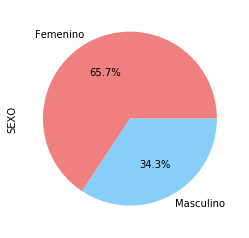

In [3]:
data['SEXO'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                 labels=['Femenino','Masculino'],
                                 colors=['lightcoral','lightskyblue']);

La variable "Sexo" indica el género (Máculino, Femenino) de los alumnos y con base en la gráfica anterior se concluye que la mayoría de los alumnos de nuevo ingreso en la FES Iztacala son del género femenino. 

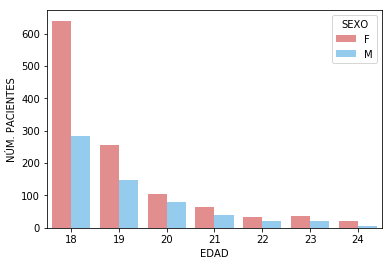

In [5]:
data["CONTEO"] = 1;
sns.barplot(x="EDAD", y="CONTEO", hue="SEXO", data=data, estimator=sum, 
           palette=['lightcoral','lightskyblue']).set_ylabel("NÚM. PACIENTES");

De los gráficos anteriores se deduce que la mayoría de los alumnos de nuevo ingreso a la FES Iztacala son mujeres de entre 18 y 19 años de edad. \\

Debido a la cantidad de información con la que se cuenta no sería viable hacer un muestreo de los datos para tener una muestra balanceada (50 y 50) de ambos géneros y tampoco se podría tener una muestra balanceada de observaciones por cada grupo de edad. Es por esto que los resultados obtenidos no pueden ser generalizados a todos los jóvenes mexicanos, únicamente aplica a la población de jóvenes que son alumnos de nuevo ingreso a la FES Iztacala. 

## Análisis de las variables numéricas

Ahora se hace el cálculo de los principales estadísticos de las variables que contienen las medidas antropométricas de los pacientes y se hace un análisis de la distribución de las mismas:

In [6]:
var_explanatory= [x for x in data.columns if x not in ['ID_EVENTO','SMet','HDL','TRI',
                                                       'TARGET_TRI','TARGET_HDL',
                                                       'CONTEO','EDAD','SEXO']]
data[var_explanatory].describe()

,PAD,PAS,PAM,GLU,CC,PESO,TALLA,IMC,CC_AGUA,CC_GRAS,CC_HUES,CC_MUSC,P_AGUA,P_GRAS,P_HUES,P_MUSC,VFA
count,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000,1757.000
mean,71.783,106.933,83.500,90.583,81.360,62.719,162.372,23.707,32.214,18.741,3.049,8.715,51.799,29.288,4.911,14.002,60.008
std,8.727,11.743,8.854,8.178,11.194,13.342,8.262,4.237,7.029,8.680,0.626,1.954,7.219,9.766,0.640,1.990,34.406
min,40.000,64.000,48.000,60.000,42.500,38.370,137.000,14.889,17.300,1.500,1.470,4.800,33.779,2.703,2.603,9.167,5.000
25%,66.000,100.000,77.333,86.000,73.500,52.930,156.000,20.624,26.900,12.600,2.590,7.200,46.562,22.492,4.488,12.564,38.200
50%,70.000,110.000,83.333,90.000,80.000,60.400,162.000,22.917,30.400,17.400,2.910,8.200,51.236,30.035,4.936,13.809,56.800
75%,80.000,112.000,90.000,95.000,87.500,70.040,168.000,26.203,36.900,23.800,3.420,10.000,56.708,36.353,5.358,15.345,78.300
max,120.000,160.000,127.333,220.000,126.000,127.900,188.000,43.415,67.800,65.300,7.060,19.100,74.403,53.931,9.431,20.650,479.600


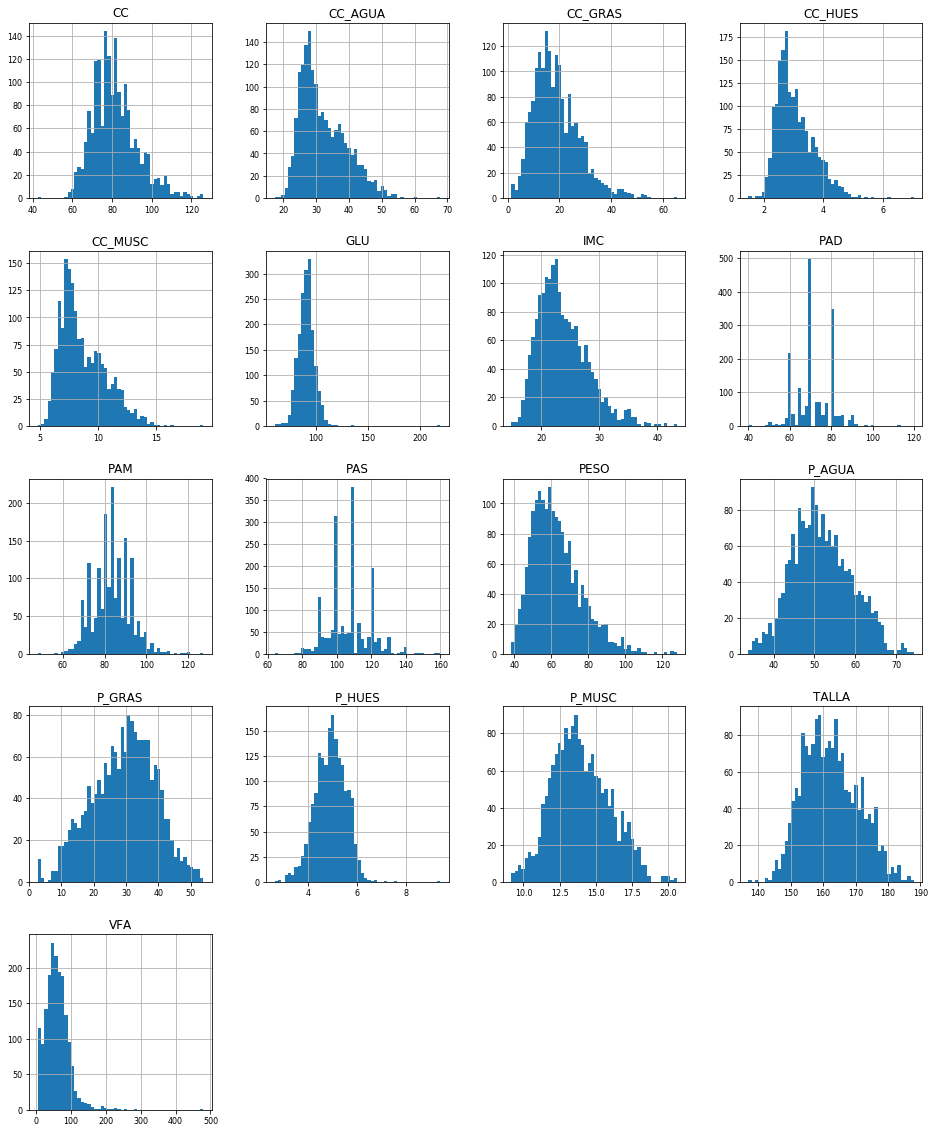

In [7]:
data[var_explanatory].hist(figsize=(16, 20), bins=50, xlabelsize=8, 
                           ylabelsize=8);

## Selección de variables

Una paso importante antes de comenzar con la construcción de los modelos predictivos es la selección de variables, es decir, la selección de aquellas medidas que ayudarán a explicar el fenómeno a ser modelado. Para poder realizar esta selección de variables se tomarán en cuenta dos estadísticos: el information value (IV) y el coeficiente de correlación. 

### Information Value

El IV ayuda a clasificar las variables en función de su importancia HACER REFERENCIA A PARTE TEÓRICA. A continuación, se construye la función que calcula el IV:

In [22]:
def iv_report(df,columna,obj):
    iv_list=[]
    for feat in columna:
        lista=[]
        for var in set(df[feat].values):
            PNE = float(len(df[(df[obj]==0) & (df[feat]==var)]))/float(len(df[df[obj]==0]))
            PE = float(len(df[(df[obj]==1) & (df[feat]==var)]))/float(len(df[df[obj]==1]))
            if PNE == 0 or PE == 0:
                woe=0
            else:
                woe=(np.log(PNE/PE))
            iv=(PNE-PE)*woe
            lista.append(iv)
        iv_list.append(sum(lista))
    return pd.DataFrame(iv_list, index=columna, columns=['IV'])

IV de las variables para triglicéridos:

In [30]:
iv_tri = iv_report(data,var_explanatory,'TARGET_TRI')
iv_tri.sort_values(by='IV', ascending=False)

,IV
CC,0.739
VFA,0.656
CC_GRAS,0.599
CC_MUSC,0.565
CC_HUES,0.559
CC_AGUA,0.513
PAS,0.408
PAM,0.356
PESO,0.308
PAD,0.300


IV de las variables para Colesterol HDL:

In [31]:
iv_hdl = iv_report(data,var_explanatory,'TARGET_HDL')
iv_hdl.sort_values(by='IV', ascending=False)

,IV
CC_MUSC,0.609
CC_AGUA,0.577
CC,0.571
CC_GRAS,0.568
CC_HUES,0.566
VFA,0.472
PAM,0.383
PESO,0.304
PAS,0.284
PAD,0.276


### Coeficiente de correlación

El Coeficiente de Correlación de Pearson es utilizado en estadística para medir qué tan fuerte es una relación entre dos variables HACER REFERENCIA A PARTE TEÓRICA. A continuación, se presenta un gráfico que ayuda a identificar la correlación entre las variables numéricas consideradas:

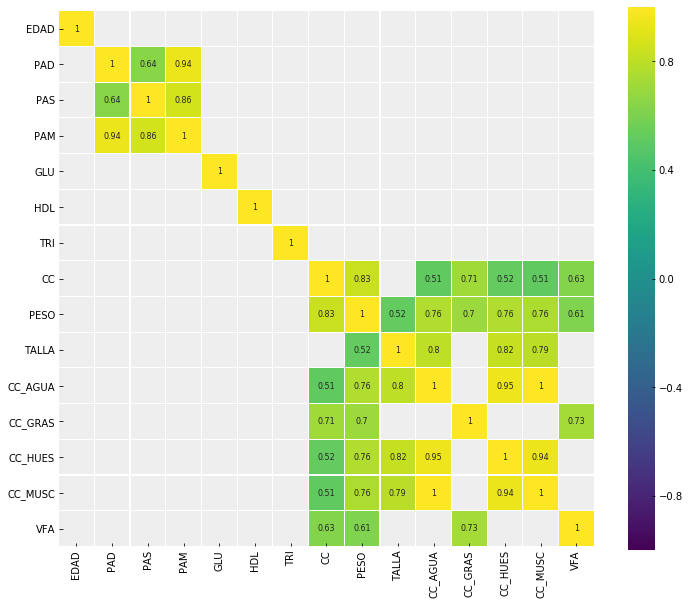

In [32]:
with plt.style.context('bmh'):
    
    corr = data.drop(columns=['ID_EVENTO','SMet','CONTEO',
                              'TARGET_TRI','TARGET_HDL',
                              'P_HUES','P_AGUA','P_GRAS',
                              'P_MUSC','IMC'], axis=1).corr()
    plt.figure(figsize=(12, 10))

    sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, 
                square=True);

plt.show() 